In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
%matplotlib inline

In [58]:
df = pd.read_csv("AEP_hourly.csv")
print("="*50)
print("First Five Rows ","\n")
print(df.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Five Rows  

              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None 

Describe the Dataset  

              AEP_MW
count  121273.000000
mean    15499.513717
std      2591.399065
min      9581.000000
25%     13630.000000
50%     15310.000000
75%     17200.000000
max     25695.000000 

Null Values t  

Datetime    0
AEP_MW      0
dtype: int64 



In [59]:
# Extract all Data Like Year MOnth Day Time etc
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)
dataset.head(1)

<ipython-input-59-71cefd3f5679>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.week


,AEP_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,01:00:00,53,Friday


In [60]:
# How many Unique Year do we Have in Dataset 
print(df.Year.unique(),"\n")
print("Total Number of Unique Year", df.Year.nunique(), "\n")

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018] 

Total Number of Unique Year 15 



No handles with labels found to put in legend.


Text(0.5, 1.0, 'Energy Consumption According to Year')

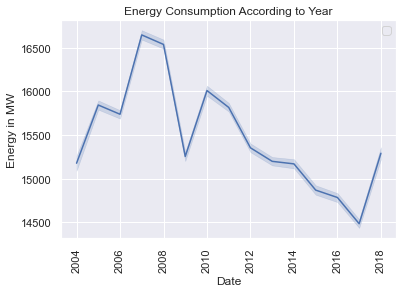

In [61]:
from matplotlib import style

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')

sns.lineplot(x=dataset["Year"], y=dataset["AEP_MW"], data=df)
sns.set(rc={'figure.figsize':(15,6)})

plt.title("Energy consumptionnin Year 2004")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("Energy Consumption According to Year")

In [62]:
# from matplotlib import style


# fig = plt.figure()

# ax1= fig.add_subplot(311)
# ax2= fig.add_subplot(312)
# ax3= fig.add_subplot(313)


# style.use('ggplot')

# y_2004 = dataset["2004"]["AEP_MW"].to_list()
# x_2004 = dataset["2004"]["Date"].to_list()
# ax1.plot(x_2004,y_2004, color="green", linewidth=1.7)


# y_2005 = dataset["2005"]["AEP_MW"].to_list()
# x_2005 = dataset["2005"]["Date"].to_list()
# ax2.plot(x_2005, y_2005, color="green", linewidth=1)


# y_2006 = dataset["2006"]["AEP_MW"].to_list()
# x_2006 = dataset["2006"]["Date"].to_list()
# ax3.plot(x_2006, y_2006, color="green", linewidth=1)


# plt.rcParams["figure.figsize"] = (18,8)
# plt.title("Energy consumptionnin")
# plt.xlabel("Date")
# plt.ylabel("Energy in MW")
# plt.grid(True, alpha=1)
# plt.legend()

# for label in ax1.xaxis.get_ticklabels():
#     label.set_rotation(90)

C:\Users\jahna\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Ennergy Distribution')

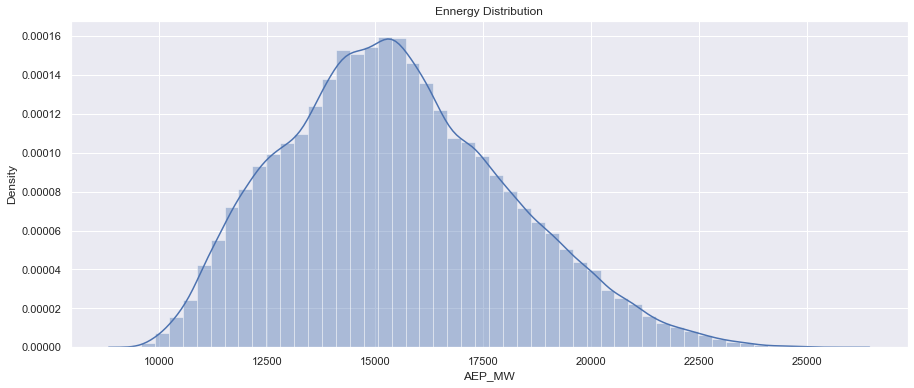

In [63]:
sns.distplot(dataset["AEP_MW"])
plt.title("Ennergy Distribution")

In [64]:
# fig = plt.figure()
# ax1= fig.add_subplot(111)

# sns.lineplot(x=dataset["Time"],y=dataset["AEP_MW"], data=df)
# plt.title("Energy Consumption vs Time ")
# plt.xlabel("Time")
# plt.grid(True, alpha=1)
# plt.legend()

# for label in ax1.xaxis.get_ticklabels():
#     label.set_rotation(90)

In [65]:
NewDataSet = dataset.resample('D').mean()

In [66]:
print("Old Dataset ",dataset.shape )
print("New  Dataset ",NewDataSet.shape )

Old Dataset  (121273, 7)
New  Dataset  (5055, 4)


In [67]:
TestData = NewDataSet.tail(100)

Training_Set = NewDataSet.iloc[:,0:1]

Training_Set = Training_Set[:-60]

In [68]:
print("Training Set Shape ", Training_Set.shape)
print("Test Set Shape ", TestData.shape)

Training Set Shape  (4995, 1)
Test Set Shape  (100, 4)


In [69]:
Training_Set = Training_Set.values
sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)

In [70]:
X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END 
for i in range(60, Train.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(Train[i-60:i])
    
    # Y Would be 60 th Value based on past 60 Values 
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(4935, 60, 1)
(4935, 1)


In [71]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(4935, 60, 1)

In [72]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [73]:
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
155/155 [==============================] - 25s 159ms/step - loss: 0.0238
Epoch 2/50
155/155 [==============================] - 26s 165ms/step - loss: 0.0184
Epoch 3/50
155/155 [==============================] - 27s 175ms/step - loss: 0.0172
Epoch 4/50
155/155 [==============================] - 26s 167ms/step - loss: 0.0163
Epoch 5/50
155/155 [==============================] - 25s 164ms/step - loss: 0.0157
Epoch 6/50
155/155 [==============================] - 26s 167ms/step - loss: 0.0153
Epoch 7/50
155/155 [==============================] - 25s 159ms/step - loss: 0.0152
Epoch 8/50
155/155 [==============================] - 25s 160ms/step - loss: 0.0130
Epoch 9/50
155/155 [==============================] - 25s 161ms/step - loss: 0.0109
Epoch 10/50
155/155 [==============================] - 25s 163ms/step - loss: 0.0098
Epoch 11/50
155/155 [==============================] - 25s 163ms/step - loss: 0.0091
Epoch 12/50
155/155 [==============================] - 26s 165ms/step - lo

In [74]:
TestData.head(2)

,AEP_MW,Month,Year,Week
Datetime,,,,
2018-04-26,13157.791667,4,2018,17
2018-04-27,12964.000000,4,2018,17


In [75]:
TestData.shape

(100, 4)

In [76]:
NewDataSet.shape

(5055, 4)

In [77]:
Df_Total = pd.concat((NewDataSet[["AEP_MW"]], TestData[["AEP_MW"]]), axis=0)

In [78]:
Df_Total.shape

(5155, 1)

In [79]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values
inputs.shape

(160, 1)

In [80]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values

# We need to Reshape
inputs = inputs.reshape(-1,1)

# Normalize the Dataset
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 160):
    X_test.append(inputs[i-60:i])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_stock_price = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [81]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = predicted_stock_price
dates = TestData.index.to_list()

In [82]:
Machine_Df = pd.DataFrame(data={
    "Date":dates,
    "TrueMegaWatt": True_MegaWatt,
    "PredictedMeagWatt":[x[0] for x in Predicted_MegaWatt ]
})

In [83]:
Machine_Df

,Date,TrueMegaWatt,PredictedMeagWatt
0,2018-04-26,13157.791667,13334.220703
1,2018-04-27,12964.000000,13170.006836
2,2018-04-28,12237.583333,14395.952148
3,2018-04-29,12156.791667,13062.543945
4,2018-04-30,13443.500000,12866.250977
...,...,...,...
95,2018-07-30,15368.083333,15159.873047
96,2018-07-31,15180.291667,15561.858398
97,2018-08-01,15151.166667,15096.771484
98,2018-08-02,15687.666667,15214.745117


In [84]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = [x[0] for x in Predicted_MegaWatt ]
dates = TestData.index.to_list()

No handles with labels found to put in legend.


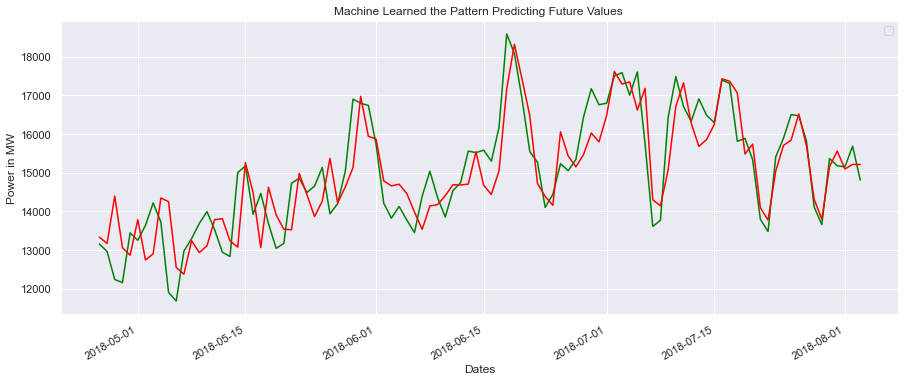

In [85]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates
y = True_MegaWatt

y1 = Predicted_MegaWatt

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Machine Learned the Pattern Predicting Future Values ")
plt.legend()

In [115]:
Testing = Machine_Df
current_date = Testing[['Date']]
current_date

0     4
1     4
2     4
3     4
4     4
     ..
95    7
96    7
97    8
98    8
99    8
Name: Date, Length: 100, dtype: int64